# Including proteins from TrEMBL with experimental evidence

In the notebook "swissprot_keywords_go_comparison", we saw that adding GO terms from the GO website to the Swissprot dataset does not provide additional samples. 

The idea for this notebook is the following:

- Filter unreviewed proteins from Uniprot by evidence for protein existence, and only keep those where the existence has been proven at protein level
- Combine this larger dataset with manually curated GO terms

This could give us a larger dataset than curated swissprot, and the data is still based on experimental evidence.

We will also try:

- Include GO-IEA terms
- Compare to keywords

Clarification:

Here, we refer to the Union of Swissprot and TrEMBL as "Uniprot". The set of all GO terms is refered to as "GO-IEA" (meaning *including* IEA). GO-NOIEA is a subset of GO-IEA, where the IEA terms have been removed.

### Datasets


Update 23.01.23: Switched to Uniprot version 2022_05

Reading data:

In [47]:
import pandas as pd
import re

# Proteins with fragmented sequences have been filtered before downloading.
df_uniprot2 = pd.read_table(
    "../data/raw/uniprot/uniprot_2022_05_evidence1-2_nofragments.tsv", index_col=0, low_memory=False
)
df_uniprot2.head()

# Only keeping existence at protein level, since the dataset also includes TrEMBL proteins.
df_uniprot2 = df_uniprot2[df_uniprot2["Protein existence"] == "Evidence at protein level"]
df_uniprot2 = df_uniprot2[["Reviewed", "Gene Ontology IDs", "Organism (ID)", "Keyword ID", "Sequence"]]
# Removing protiens with placeholder AAs:
df_uniprot2 = df_uniprot2[
    df_uniprot2.Sequence.str.match(re.compile("[ACDEFGHIKLMNPQRSTVWY]+"))
]
df_uniprot2.head()

,Reviewed,Gene Ontology IDs,Organism (ID),Keyword ID,Sequence
Entry,,,,,
A0A0C5B5G6,reviewed,GO:0001649; GO:0003677; GO:0005615; GO:0005634...,9606,KW-0238; KW-0496; KW-0539; KW-0892; KW-1185; K...,MRWQEMGYIFYPRKLR
A0A1B0GTW7,reviewed,GO:0004222; GO:0005737; GO:0006508; GO:0007155...,9606,KW-0025; KW-0225; KW-0325; KW-1056; KW-0378; K...,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...
A0JNW5,reviewed,GO:0005769; GO:0005829; GO:0034498; GO:0042803...,9606,KW-0025; KW-0175; KW-0963; KW-0967; KW-0597; K...,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
A0JP26,reviewed,NaN,9606,KW-0025; KW-0040; KW-0175; KW-1185; KW-0677,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
A0PK11,reviewed,GO:0007605; GO:0032421; GO:0060088; GO:0060171...,9606,KW-1003; KW-0966; KW-0209; KW-0225; KW-0325; K...,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...


Parsing the GO terms:

In [22]:
df_uniprot_go = df_uniprot["Gene Ontology IDs"].rename("go_id")
df_uniprot_go = df_uniprot_go[~df_uniprot_go.isnull()]
df_uniprot_go = df_uniprot_go.str.split(";").explode().str.strip()
df_uniprot_go = df_uniprot_go.reset_index(drop=False)
df_uniprot_go.head()

,Entry,go_id
0,A0A0C5B5G6,GO:0001649
1,A0A0C5B5G6,GO:0003677
2,A0A0C5B5G6,GO:0005615
3,A0A0C5B5G6,GO:0005634
4,A0A0C5B5G6,GO:0005739


Subset of Swissprot GO terms:

In [23]:
swissprot_proteins = set(df_uniprot[df_uniprot.Reviewed == "reviewed"].index.to_list())
df_swissprot_go = df_uniprot_go[
    df_uniprot_go.Entry.isin(swissprot_proteins)
].reset_index(drop=True)

Loading the ontology:

In [24]:
from subpred.go_utils import GeneOntology

go = GeneOntology("../data/raw/ontologies/go.owl")

GO term sets:

In [25]:
transmembrane_transport_descendants = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
amino_acid_descendants = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
carbohydrate_descendants = go.get_descendants(
    go.get_identifier("carbohydrate transmembrane transporter activity")
)
sugar_descendants = go.get_descendants(
    go.get_identifier("sugar transmembrane transporter activity")
)
ion_descendants = go.get_descendants(
    go.get_identifier("ion transmembrane transporter activity")
)


### GO dataset from GO website (No-IEA)

In [26]:
df_go_noiea = pd.read_table(
    "../data/raw/gene_ontology/goa_uniprot_all_noiea.gaf.gz",
    header=None,
    names=[
        "db",
        "db_object_id",
        "db_object_symbol",
        "qualifier",
        "go_id",
        "db_reference",
        "evidence_code",
        "with_or_from",
        "aspect",
        "db_object_name",
        "db_object_synonym",
        "db_object_type",
        "taxon",
        "date",
        "assigned_by",
        "annotation_extension",
        "gene_product_form_id",
    ],
)
df_go_noiea.head()


,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id
0,UniProtKB,Q5R8N4,VPS35L,located_in,GO:0005768,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,C,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190110,UniProt,NaN,NaN
1,UniProtKB,Q5R8N4,VPS35L,involved_in,GO:0032456,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,P,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190114,UniProt,NaN,NaN
2,UniProtKB,Q87UX2,blc,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
3,UniProtKB,Q87UX2,blc,involved_in,GO:0008150,GO_REF:0000015,ND,NaN,P,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
4,UniProtKB,C8VDI1,AN11006,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein AN11006,AN11006,protein,taxon:227321,20200401,AspGD,NaN,NaN


Filtering for "enables" qualifier (protein is directly responsible for the function), and UniProt entries (as opposed to other gene products like mRNA)

In [27]:
df_go_noiea = df_go_noiea[
    (df_go_noiea.db == "UniProtKB")
    & (df_go_noiea.qualifier == "enables")
    & (df_go_noiea.aspect == "F")
]
df_go_noiea = df_go_noiea[["db_object_id", "go_id"]]
df_go_noiea = df_go_noiea[df_go_noiea.db_object_id.isin(df_uniprot.index)]
df_go_noiea = df_go_noiea.reset_index(drop=True).rename(
    columns={"db_object_id": "Uniprot"}
)
df_go_noiea


,Uniprot,go_id
0,Q93AM0,GO:0008047
1,Q9A9T8,GO:0005515
2,P04014,GO:0003678
3,P04014,GO:0003677
4,P04014,GO:0003677
...,...,...
24049,P00180,GO:0005515
24050,A1C3L9,GO:0016757
24051,A1C3L9,GO:0016757
24052,A1C3L9,GO:0005515


### Go dataset (IEA)

Preprocessed file, only contains "enables" qualifier and "molecular function" terms

In [28]:
df_go_iea = pd.read_table(
    "../data/raw/gene_ontology/goa_sp_iea_mf_enables.tsv.xz",
    header=None,
    names=["Uniprot", "go_id", "evidence_code"],
)

In [29]:
df_go_iea = df_go_iea[df_go_iea.Uniprot.isin(df_uniprot.index)]

Is filtering IEA terms from the larger file the same as reading the no-iea file?

The resulting Venn diagrams were the same, but do they contain exactly the same annotations?

In [30]:
df_go_noiea2 = (
    df_go_iea[df_go_iea.evidence_code != "IEA"]
    .rename(columns={"db_object_id": "Uniprot"})
    .drop("evidence_code", axis=1)
    .reset_index(drop=True)
)
(
    df_go_noiea.sort_values(["Uniprot", "go_id"]).reset_index(drop=True)
    == df_go_noiea2.sort_values(["Uniprot", "go_id"]).reset_index(drop=True)
).all()


Uniprot    True
go_id      True
dtype: bool

Yes, they are the same. We can just read the smaller file if we don't need IEA annotations

## Venn diagrams

In [31]:
from venn import venn
import matplotlib.pyplot as plt


def venn_plot_go(go_set: set):
    tmt_swissprot = set(
        df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list()
    )
    tmt_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
    tmt_go_noiea = set(df_go_noiea[df_go_noiea.go_id.isin(go_set)].Uniprot.to_list())
    tmt_go_iea = set(df_go_iea[df_go_iea.go_id.isin(go_set)].Uniprot.to_list())
    venn(
        {
            "go-swissprot": tmt_swissprot,
            "go-uniprot": tmt_uniprot,
            "go-noiea": tmt_go_noiea,
            "go-iea": tmt_go_iea,
        }
    )


### Transmembrane transporters

Adding TrEMBL transporters more than doubles the number of samples. There is also a considerable overlap with GO-IEA annotations for both Uniprot datasets. We will explore later if these are the keywords (keywords are included in GO as IEA terms).

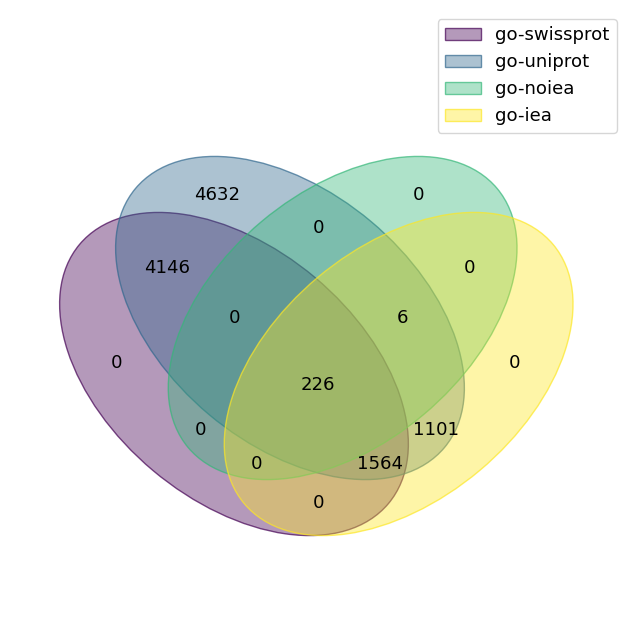

In [33]:
venn_plot_go(transmembrane_transport_descendants)

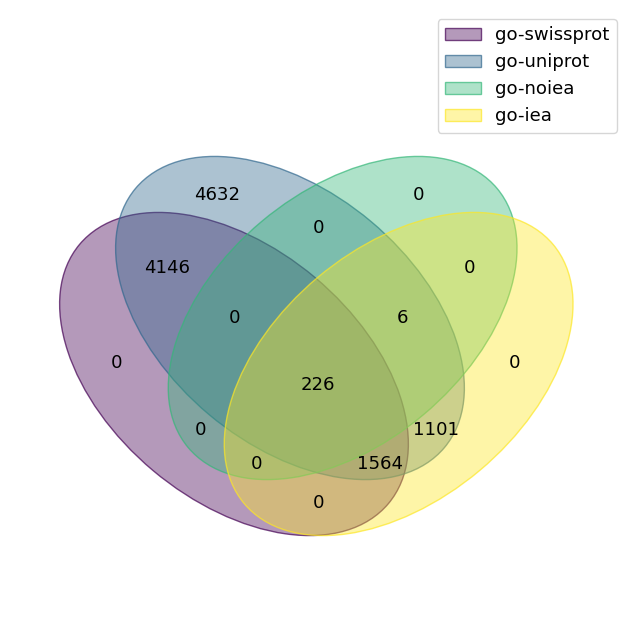

In [34]:
venn_plot_go(transmembrane_transport_descendants)

### Sugar

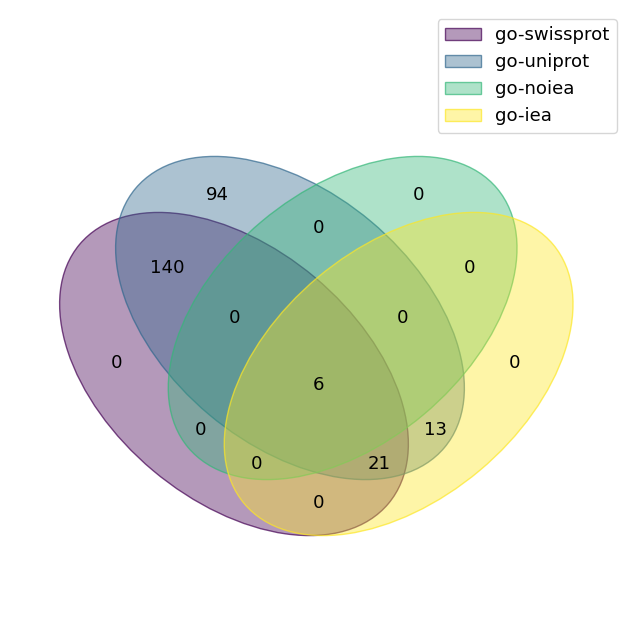

In [35]:
venn_plot_go(sugar_descendants)

### Carbohydrate

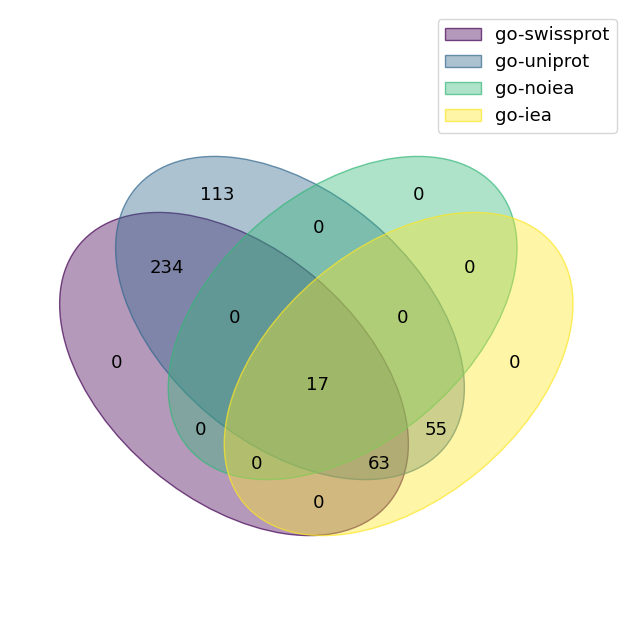

In [36]:
venn_plot_go(carbohydrate_descendants)

### Amino acid

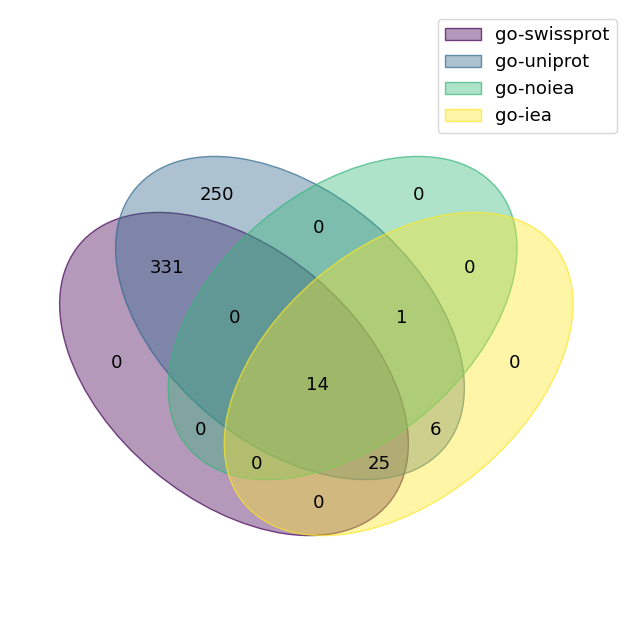

In [37]:
venn_plot_go(amino_acid_descendants)

## Keywords

Roughly equivalent keywords:

- Transport (KW-0813)
- Transmembrane (KW-0812)
- Sugar transport: KW-0762
- Amino-acid transport: 
- Ion transport: KW-0406

In [38]:
keywords = {
    "Transmembrane": "KW-0812",
    "Transport": "KW-0813",
    "Sugar transport": "KW-0762",
    "Amino-acid transport": "KW-0029",
    "Ion transport": "KW-0406",
}


In [39]:
df_uniprot_kw = df_uniprot["Keyword ID"].rename("kw_ids")
df_uniprot_kw = df_uniprot_kw[~df_uniprot_kw.isnull()]
df_uniprot_kw = df_uniprot_kw.str.split(";").explode().str.strip()
df_uniprot_kw = df_uniprot_kw.reset_index(drop=False)
df_uniprot_kw = df_uniprot_kw.merge(
    df_uniprot.Reviewed, how="inner", left_on="Entry", right_index=True
)
df_uniprot_kw.head()


,Entry,kw_ids,Reviewed
0,A0A0C5B5G6,KW-0238,reviewed
1,A0A0C5B5G6,KW-0496,reviewed
2,A0A0C5B5G6,KW-0539,reviewed
3,A0A0C5B5G6,KW-0892,reviewed
4,A0A0C5B5G6,KW-1185,reviewed


In [40]:
transmembrane_proteins = df_uniprot_kw[
    df_uniprot_kw.kw_ids == keywords["Transmembrane"]
].Entry.unique()
df_uniprot_kw_transmembrane = df_uniprot_kw[
    df_uniprot_kw.Entry.isin(transmembrane_proteins)
].reset_index(drop=True)

df_uniprot_kw_transmembrane.head()


,Entry,kw_ids,Reviewed
0,A0A1B0GTW7,KW-0025,reviewed
1,A0A1B0GTW7,KW-0225,reviewed
2,A0A1B0GTW7,KW-0325,reviewed
3,A0A1B0GTW7,KW-1056,reviewed
4,A0A1B0GTW7,KW-0378,reviewed


### How do the Keywords protein sets compare to the Uniprot GO sets?

We already figured out that the official GO datasets are a subset of the Uniprot GO sets. What is the overlap between Uniprot-GO and Uniprot-Keyword?

#### Creating protein sets for keywords

In [41]:
def venn_plot_kw(go_set: set, keyword: str):
    go_swissprot = set(
        df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list()
    )
    go_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
    kw_uniprot = set(
        df_uniprot_kw_transmembrane[
            (df_uniprot_kw_transmembrane.kw_ids == keyword)
        ].Entry.unique()
    )
    kw_swissprot = set(
        df_uniprot_kw_transmembrane[
            (df_uniprot_kw_transmembrane.kw_ids == keyword)
            & (df_uniprot_kw_transmembrane.Reviewed == "reviewed")
        ].Entry.unique()
    )
    venn(
        {
            "go-swissprot": go_swissprot,
            "go-uniprot": go_uniprot,
            "kw-swissprot": kw_swissprot,
            "kw-uniprot": kw_uniprot,
        }
    )


#### Transmembrane transport

The keyword annotations add 1638 proteins when only looking at manual annotations, and 4704 when also including electronic Keyowrd annotations. These electronic annotations have a significant overlap of 3099 proteins with the GO terms from TrEMBL. A similar pattern occurs for the substrates below.

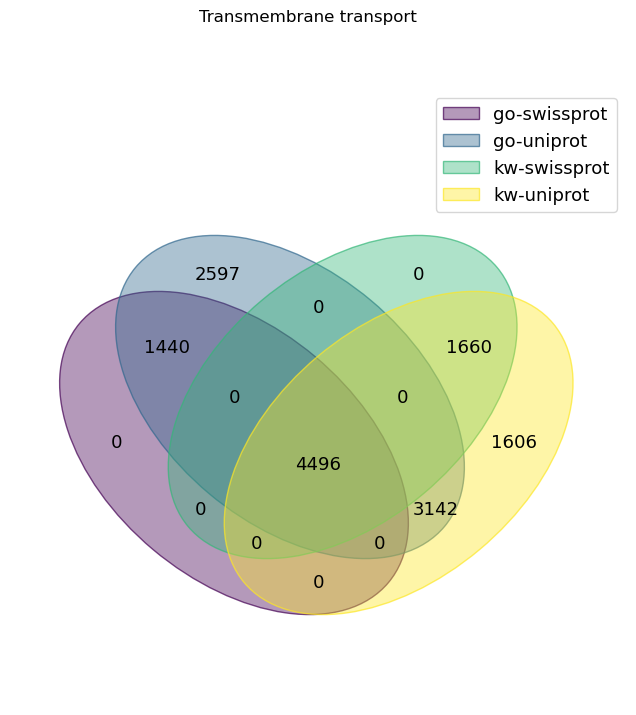

In [42]:
venn_plot_kw(transmembrane_transport_descendants, keywords["Transport"])
plt.suptitle("Transmembrane transport")
plt.show()

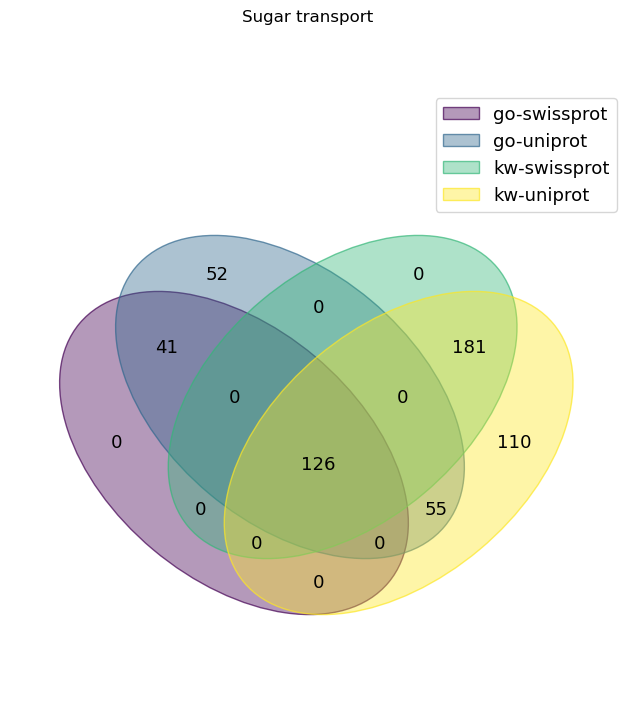

In [43]:
venn_plot_kw(sugar_descendants, keywords["Sugar transport"])
plt.suptitle("Sugar transport")
plt.show()


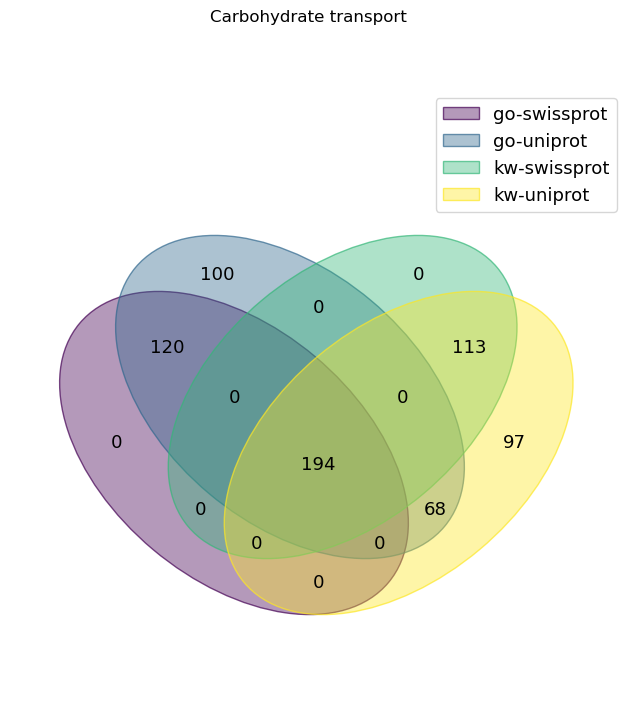

In [44]:
venn_plot_kw(carbohydrate_descendants, keywords["Sugar transport"])
plt.suptitle("Carbohydrate transport")
plt.show()


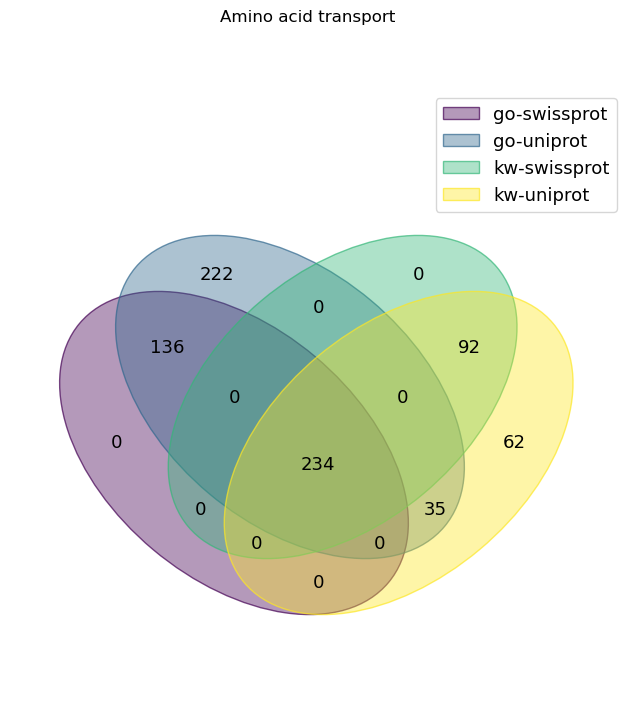

In [45]:
venn_plot_kw(amino_acid_descendants, keywords["Amino-acid transport"])
plt.suptitle("Amino acid transport")
plt.show()


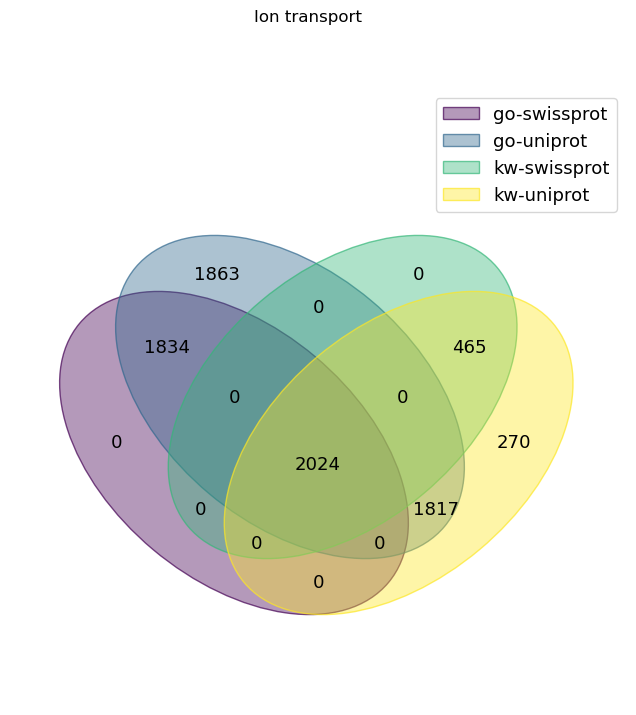

In [46]:
venn_plot_kw(ion_descendants, keywords["Ion transport"])
plt.suptitle("Ion transport")
plt.show()


### How many GO terms/Keywords in TrEMBL are mapped to IEA terms?

Do TrEMBL proteins only have IEA GO terms, or is there a considerable number of non-IEA transmembrane transporter GO annotations for TrEMBL proteins? 

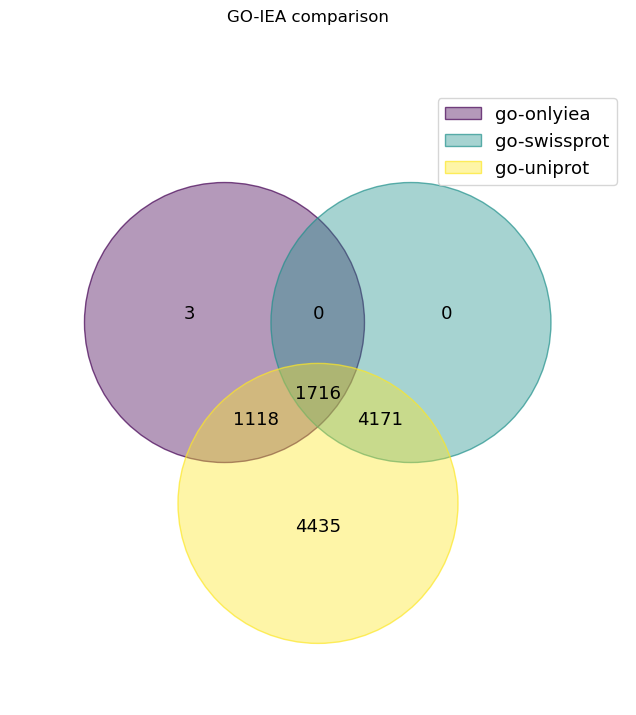

In [43]:
go_set = transmembrane_transport_descendants
keyword = keywords["Transport"]
df_go_iea_only = df_go_iea[df_go_iea.evidence_code == "IEA"]
tmt_go_only_iea = set(
    df_go_iea_only[df_go_iea_only.go_id.isin(go_set)].Uniprot.to_list()
)
go_swissprot = set(df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list())
go_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
venn(
    {
        "go-onlyiea": tmt_go_only_iea,
        "go-swissprot": go_swissprot,
        "go-uniprot": go_uniprot,
    }
)
plt.suptitle("GO-IEA comparison")
plt.show()


Virtually all GO IEA annotations are included in Uniprot. Of all the transmembrane transport GO anntations of Swissprot+TrEMBL proteins, 2834 are marked as IEA, 1716 of which are in Swissprot. Since Swissprot is manually curated, we can assume that these IEA terms were assigned to the Swissprot entry by a curator. 

This plot shows us that the majority of transmembrane transporter GO annotations in TrEMBL are non-IEA GO terms, and can therefore be used for out training dataset.

The latter is also true for keywords, although there is a larger number of annotations where only IEA terms exist. The lower overlap could be caused by the fact that combining the Transport and Transmembrane keywords is only a rough estimate of the more accurate "transmembrane transporters activity" GO term.

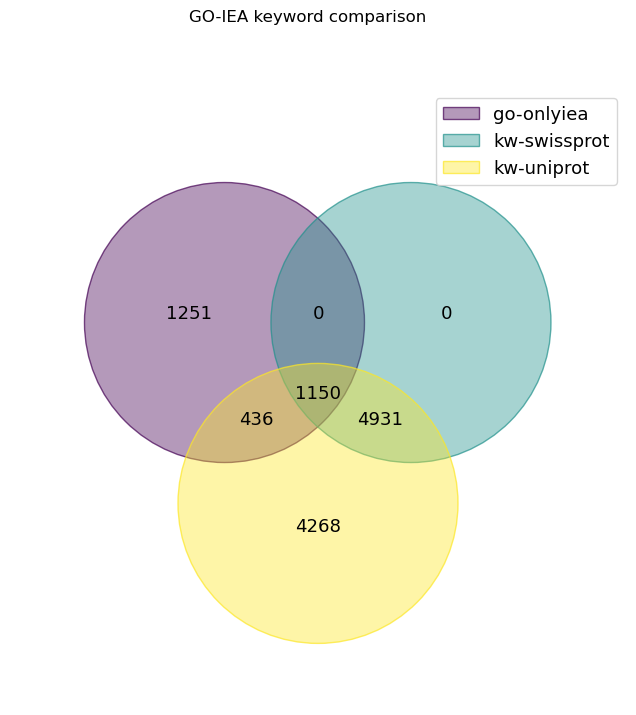

In [44]:
go_set = transmembrane_transport_descendants
keyword = keywords["Transport"]
df_go_iea_only = df_go_iea[df_go_iea.evidence_code == "IEA"]
tmt_go_only_iea = set(
    df_go_iea_only[df_go_iea_only.go_id.isin(go_set)].Uniprot.to_list()
)
kw_uniprot = set(
    df_uniprot_kw_transmembrane[
        (df_uniprot_kw_transmembrane.kw_ids == keyword)
    ].Entry.unique()
)
kw_swissprot = set(
    df_uniprot_kw_transmembrane[
        (df_uniprot_kw_transmembrane.kw_ids == keyword)
        & (df_uniprot_kw_transmembrane.Reviewed == "reviewed")
    ].Entry.unique()
)
venn(
    {
        "go-onlyiea": tmt_go_only_iea,
        "kw-swissprot": kw_swissprot,
        "kw-uniprot": kw_uniprot,
    }
)
plt.suptitle("GO-IEA keyword comparison")
plt.show()


In [8]:
df_go_noiea_all = pd.read_table(
    "../data/raw/gene_ontology/goa_uniprot_all_noiea.gaf.gz",
    header=None,
    names=[
        "db",
        "db_object_id",
        "db_object_symbol",
        "qualifier",
        "go_id",
        "db_reference",
        "evidence_code",
        "with_or_from",
        "aspect",
        "db_object_name",
        "db_object_synonym",
        "db_object_type",
        "taxon",
        "date",
        "assigned_by",
        "annotation_extension",
        "gene_product_form_id",
    ],
)
df_go_noiea_all = df_go_noiea_all[
    ["db_object_id", "go_id", "qualifier", "evidence_code", "aspect", "date"]
]
df_go_noiea_all = df_go_noiea_all.rename(columns={"db_object_id": "Uniprot"})
print("annotations in go-noiea:", df_go_noiea_all.drop_duplicates().shape[0])
df_go_noiea_all.head()


annotations in go-noiea: 286035


,Uniprot,go_id,qualifier,evidence_code,aspect,date
0,Q5R8N4,GO:0005768,located_in,ISS,C,20190110
1,Q5R8N4,GO:0032456,involved_in,ISS,P,20190114
2,Q87UX2,GO:0003674,enables,ND,F,20061207
3,Q87UX2,GO:0008150,involved_in,ND,P,20061207
4,C8VDI1,GO:0003674,enables,ND,F,20200401


In [46]:
df_uniprot_go = df_uniprot_go.rename(columns={"Entry": "Uniprot"})
print("annotations in go-uniprot:", df_uniprot_go.drop_duplicates().shape[0])
df_uniprot_go.head()


annotations in go-uniprot: 1678112


,Uniprot,go_id
0,A0A0C5B5G6,GO:0001649
1,A0A0C5B5G6,GO:0003677
2,A0A0C5B5G6,GO:0005615
3,A0A0C5B5G6,GO:0005634
4,A0A0C5B5G6,GO:0005739


What is the distribution of qualifiers in Uniprots GO annotations?

In [47]:
df_uniprot_merged = pd.merge(
    df_uniprot_go, df_go_noiea_all, how="inner", on=["Uniprot", "go_id"]
)
# df_uniprot_merged[~df_uniprot_merged.qualifier.isnull()]
df_uniprot_merged[df_uniprot_merged.aspect == "F"].qualifier.value_counts()


enables           14662
contributes_to       42
NOT|enables          11
Name: qualifier, dtype: int64

According to the Uniprot documentation, the latter two qualifiers should have been removed! Although the number is very small, compared to the many "enables" qualifiers. That is already a good sign, but we should test the same thing with the GO-IEA data.

The reason for this difference could be the fact that Uniprot GO data is three months out of date. Maybe those qualifiers were changes that happened since then?

In [48]:
df_uniprot_merged[
    (df_uniprot_merged.aspect == "F") & (df_uniprot_merged.qualifier == "NOT|enables")
]


,Uniprot,go_id,qualifier,evidence_code,aspect,date
6097,Q9XF59,GO:0015250,NOT|enables,TAS,F,20090413
10067,Q9DGW5,GO:0008134,NOT|enables,IPI,F,20080915
15410,G8JZS4,GO:0004558,NOT|enables,IDA,F,20140603
17242,P9WID5,GO:0004001,NOT|enables,IDA,F,20110608
18409,Q75N34,GO:0004089,NOT|enables,IDA,F,20200403
18411,Q75N34,GO:0004867,NOT|enables,IDA,F,20200403
21492,P9WIS5,GO:0008683,NOT|enables,IDA,F,20120701
21504,P9WIU5,GO:0015288,NOT|enables,IDA,F,20120206
30683,A0A6G9KHD3,GO:0090729,NOT|enables,IDA,F,20210310
31100,O06553,GO:0010181,NOT|enables,IDA,F,20170413


No, that does not seem to be the case. The latest date is from 2020.

### Annotating Uniprot GO terms with complete GO file (including IEA)

#### Reading the data, preprocessing:

In [157]:
df_go_iea_complete = pd.read_table(
    "~/gene_ontology/goa_uniprot_all_filtered.gaf", index_col=False
)
df_go_iea_complete


,Uniprot,qualifier,go_id,evidence_code,aspect,date
0,Q6ESQ0,enables,GO:0003677,IEA,F,20220907
1,Q6ESQ0,located_in,GO:0005634,IEA,C,20220907
2,Q6ESQ0,located_in,GO:0005634,IEA,C,20220907
3,Q6ESQ0,enables,GO:0003677,IEA,F,20220907
4,Q6ESQ0,located_in,GO:0005634,IEA,C,20220907
...,...,...,...,...,...,...
645559,Q02322,involved_in,GO:0006260,IEA,P,20220907
645560,Q02322,involved_in,GO:0006281,IEA,P,20220907
645561,Q02322,involved_in,GO:0006974,IEA,P,20220907
645562,Q02322,enables,GO:0042802,IPI,F,20220910


In [158]:
df_merged_iea = pd.merge(
    df_uniprot_go, df_go_iea_complete, how="left", on=["Uniprot", "go_id"]
).drop_duplicates(ignore_index=True)
df_merged_iea

,Uniprot,go_id,qualifier,evidence_code,aspect,date
0,A0A0C5B5G6,GO:0001649,NaN,NaN,NaN,NaN
1,A0A0C5B5G6,GO:0003677,NaN,NaN,NaN,NaN
2,A0A0C5B5G6,GO:0005615,NaN,NaN,NaN,NaN
3,A0A0C5B5G6,GO:0005634,NaN,NaN,NaN,NaN
4,A0A0C5B5G6,GO:0005739,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1694603,W8W3V2,GO:0005549,enables,IEA,F,20220907.0
1694604,X5EH37,GO:0008289,enables,IEA,F,20220907.0
1694605,X5I2D7,GO:0000166,enables,IEA,F,20220907.0
1694606,X5I2D7,GO:0005576,located_in,IEA,C,20220907.0


In [159]:
def map_reviewed(x):
# default case does not occur here, but including it just in case
    match(x):
        case "reviewed":
            return True
        case "unreviewed":
            return False
        case _:
            return "NA"
df_merged_iea = df_merged_iea.merge(
    df_uniprot.Reviewed.rename("reviewed").apply(map_reviewed).convert_dtypes("bool"),
    how="left",
    left_on="Uniprot",
    right_index=True,
)
df_merged_iea = df_merged_iea.reset_index(drop=True)

In [160]:
from subpred.go_utils import EVIDENCE_CODE_TO_DESCRIPTION

df_merged_iea = df_merged_iea.assign(
    evidence_description=df_merged_iea.evidence_code.map(EVIDENCE_CODE_TO_DESCRIPTION)
)
df_merged_iea.evidence_description = df_merged_iea.evidence_description.fillna("Not Available")
df_merged_iea.qualifier = df_merged_iea.qualifier.fillna("Not Available")
df_merged_iea = df_merged_iea.drop_duplicates()
df_merged_iea

,Uniprot,go_id,qualifier,evidence_code,aspect,date,reviewed,evidence_description
0,A0A0C5B5G6,GO:0001649,Not Available,NaN,NaN,NaN,True,Not Available
1,A0A0C5B5G6,GO:0003677,Not Available,NaN,NaN,NaN,True,Not Available
2,A0A0C5B5G6,GO:0005615,Not Available,NaN,NaN,NaN,True,Not Available
3,A0A0C5B5G6,GO:0005634,Not Available,NaN,NaN,NaN,True,Not Available
4,A0A0C5B5G6,GO:0005739,Not Available,NaN,NaN,NaN,True,Not Available
...,...,...,...,...,...,...,...,...
1694603,W8W3V2,GO:0005549,enables,IEA,F,20220907.0,False,electronic_annotation
1694604,X5EH37,GO:0008289,enables,IEA,F,20220907.0,False,electronic_annotation
1694605,X5I2D7,GO:0000166,enables,IEA,F,20220907.0,False,electronic_annotation
1694606,X5I2D7,GO:0005576,located_in,IEA,C,20220907.0,False,electronic_annotation


### Distribution of Evidence codes

GO terms that are manually annotated by Uniprot curators are still listed as "electronic annotation" in GO, so this might not be completely accurate:

##### All GO terms:

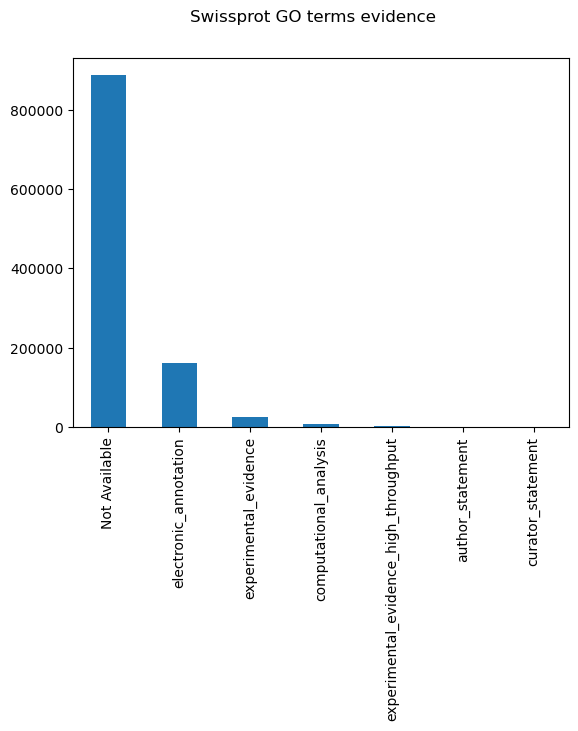

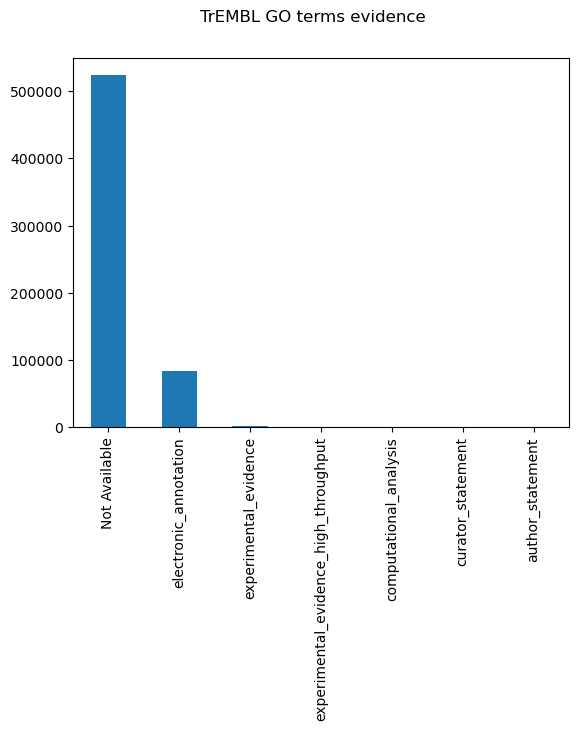

In [161]:
df_merged_iea[df_merged_iea.reviewed].evidence_description.value_counts().plot.bar()
plt.suptitle("Swissprot GO terms evidence")
plt.show()
df_merged_iea[~df_merged_iea.reviewed].evidence_description.value_counts().plot.bar()
plt.suptitle("TrEMBL GO terms evidence")
plt.show()

For the vast majority of GO annotations in Uniprot, a corresponding entry in the official GO database does not seem to exist. The remaining GO terms are mostly IEA terms. Is that also the case for transmembrane transporters?

##### Transmembrane transporter GO terms:

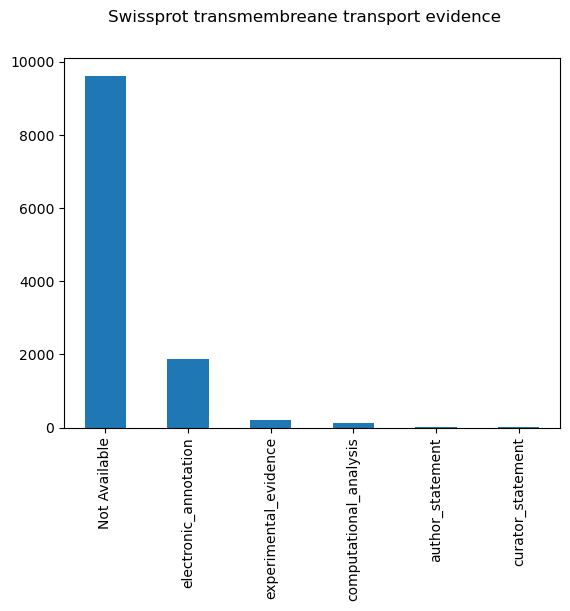

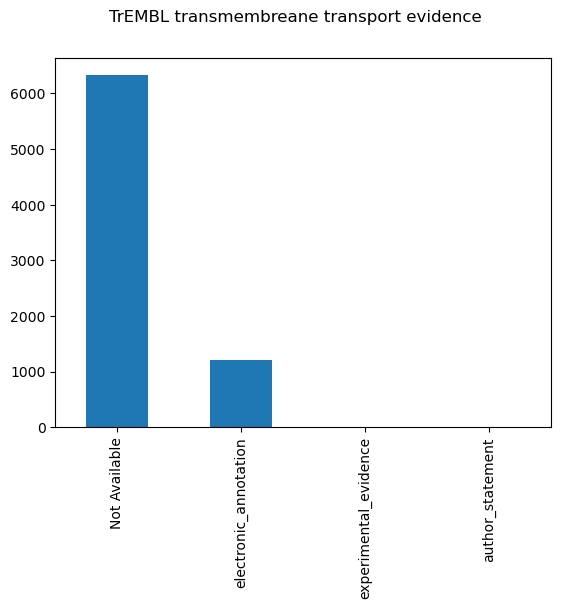

In [162]:
df_merged_iea[
    df_merged_iea.reviewed
    & df_merged_iea.go_id.isin(transmembrane_transport_descendants)
].evidence_description.value_counts().plot.bar()
plt.suptitle("Swissprot transmembreane transport evidence")
plt.show()
df_merged_iea[
    ~df_merged_iea.reviewed
    & df_merged_iea.go_id.isin(transmembrane_transport_descendants)
].evidence_description.value_counts().plot.bar()
plt.suptitle("TrEMBL transmembreane transport evidence")
plt.show()


Yes, it is also the case for transmembrane transporters.

#### Qualifiers

Qualifiers show the relation between a GO term and a protein. Enables is what we want, that means the protein is directly responsible for the function.

What is the distribution of qualifiers in Swissprot and TrEMBL?

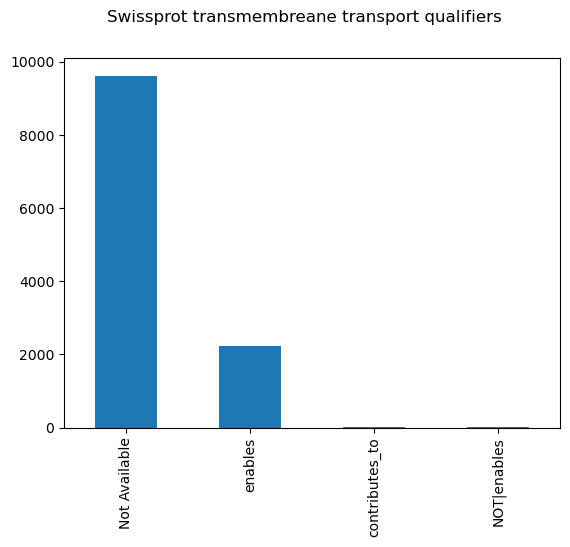

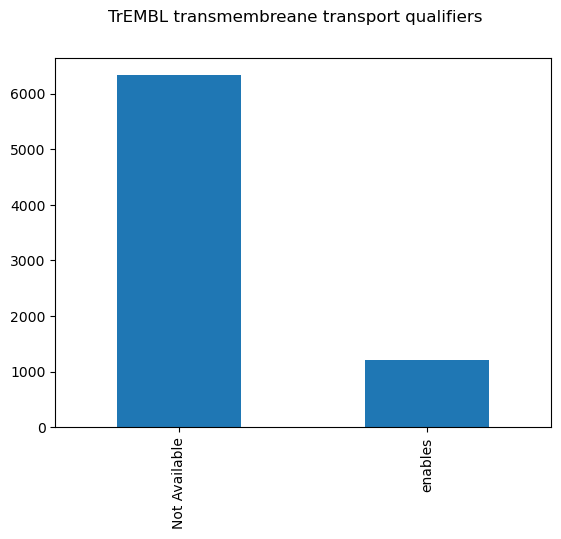

In [163]:
df_merged_iea[
    df_merged_iea.reviewed
    & df_merged_iea.go_id.isin(transmembrane_transport_descendants)
].qualifier.value_counts().plot.bar()
plt.suptitle("Swissprot transmembreane transport qualifiers")
plt.show()
df_merged_iea[
    ~df_merged_iea.reviewed
    & df_merged_iea.go_id.isin(transmembrane_transport_descendants)
].qualifier.value_counts().plot.bar()
plt.suptitle("TrEMBL transmembreane transport qualifiers")
plt.show()

In case of Swissprot, we again find the small number of wrong qualifiers that should have caused the annotation to be removed. Uniref only has "enables". In both cases, most qualifiers are not available.

## Summary

- Combining experimentally verified proteins from TrEMBL with GO annotations from Uniprot can increase the sample size by up to 100%. 
- Using the GO datasets from the official website, as well as IEA terms, did not yield additional data.
    - In fact, many of the GO annotations included in Uniprot are not listed in the official GO dataset.
- Including manually annotated Keywords from Swissprot adds 1638 additional transporters, compared to a dataset using only GO terms.
    - Automatically annotated TrEMBL Keywords add 1605 additional annotations
- Including GO annotations for Swissprot proteins adds 1444 transporters, compared to a dataset using Keywords
    - Also including TrEMBL GO annotations adds an additional 2454 transporters
- The vast majority of transmembrane transporter GO annotations in TrEMBL have unknown evidence, and are not part of the official GO dataset.
    - The qualifiers and evidence type is not known for most GO annotations in Swissprot and TrEMBL
    - We have to assume that GO annotations in TrEMBL are IEA, if they are not explicitly part of the non-IEA dataset.
    - We can still use the intersection of GO-NOIEA and TrEMBL, although this does not add many proteins

## Conclusion

If the goal is to increase the number of samples compared to a keywords-only dataset without relying on electronically inferred information, then the dataset would be made up of the following:
- TrEMBL & Swissprot proteins
    - Protein existence verified at protein level
    - If we need more samples, we could include evidence at transcript level.
- Annotations
    - Non-IEA GO terms, filtered by "enables" qualifier
        - "Enables" means that the protein is directly responsible for the molecular function
        - Problem: We do not have qualifiers and evidence codes for Uniprot GO annotations, and most of them are not listed on the official GO website
            - Assume that Swissprot GO annotations are manual and TrEMBL GO annotations are inferred? Uniprot Help page is not clear about that. 
        - Uniprot can also contain less accurate qualifiers, but only in small numbers
    - Swissprot Keywords
        - Since TrEMBL keywords are electronically annotated.

Other ideas:
- Create a very accurate set from the overlap of verified GO terms and Keywords, for more accurate training set when there are enough samples available.
- Create a union set including all information, use for validating ML models.